In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
import random
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
import re

import keras
!pip install keras-metrics
import keras_metrics
from keras.utils import to_categorical
from keras.layers import Input, Dense, Embedding, Flatten, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import categorical_crossentropy
from keras.optimizers import Adamax
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score

nltk.download('punkt')
nltk.download('stopwords')
#nltk.download('movie_reviews')
nltk.download('wordnet')
#from nltk.corpus import movie_reviews

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
url = "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
data = pd.read_csv(url, sep='\t')
print('Shape: ' , data.shape)
data['Sentiment'].value_counts()
print(data.head())
del data['PhraseId']
del data['SentenceId']

Shape:  (156060, 4)
   PhraseId  ...  Sentiment
0         1  ...          1
1         2  ...          2
2         3  ...          2
3         4  ...          2
4         5  ...          2

[5 rows x 4 columns]


In [0]:
#porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
from string import punctuation
stopwords_en = stopwords.words("english")

In [0]:
def clean(Phrase):
    document=[]
    for i in range(len(Phrase)):
        review=re.sub('[^a-zA-Z]',' ',str(Phrase[i]))
        review=[wordnet_lemmatizer.lemmatize(w) for w in word_tokenize(str(review).lower())]
        document.append(' '.join(review))
    return document

In [0]:
data['Text']=clean(data['Phrase'])
data.head()

,Phrase,Sentiment,Text
0,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,A series,2,a series
3,A,2,a
4,series,2,series


In [0]:
# create training and testing vars
x_train, x_test, y_train, y_test = train_test_split(data['Text'], data['Sentiment'], test_size=0.3, random_state=2003)
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(109242,) (109242,)
(46818,) (46818,)


In [0]:
print(y_test.value_counts())

2    23987
3     9872
1     8070
4     2738
0     2151
Name: Sentiment, dtype: int64


In [0]:
y_test = to_categorical(y_test)
print(y_test)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


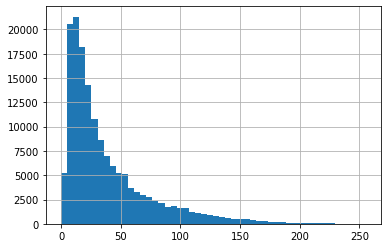

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
data['text_length'] = data['Text'].apply(len)
data['text_length'].hist(bins=50)

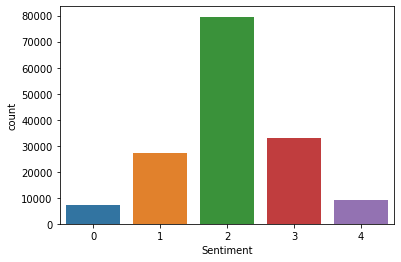

In [0]:
sns.countplot(data['Sentiment'])

In [0]:
y_temp = y_train.tolist()
x_temp = x_train.tolist() 
l = []
for i in range(len(x_temp)):
    temp = (x_temp[i],y_temp[i])
    l.append(temp)
trainData = pd.DataFrame(l,columns=['text', 'sentiment'])
trainData.head(2000)

,text,sentiment
0,their age,2
1,gorgeous epic,4
2,fan of the gross out comedy,2
3,the filmmaker ascends literally to the olympus...,4
4,twisting mystery,2
...,...,...
1995,ratliff s two previous title plutonium circus ...,3
1996,giving up on dream when you re a struggling no...,2
1997,amy and matthew have a bit of a phony relation...,3
1998,the beast and,2


In [0]:
from sklearn.utils import resample
def Resample(trainingData, sentiment):
  return resample(trainingData[trainingData['sentiment'] == sentiment],replace=True,n_samples=10000,random_state=2003)

In [0]:
temp = []
for i in range(trainData['sentiment'].nunique()):
  temp.insert(i,Resample(trainData,i))

In [0]:
data = pd.concat( temp [i] for i in range(len(temp)) )

In [0]:
data

,text,sentiment
20682,insufferably naive,0
102786,the worst film of the year,0
51945,a deadly bore,0
56380,s it s simply unbearable,0
93678,is not really a film a much a it is a loose co...,0
...,...,...
106734,is the ultimate movie experience,4
74344,stanley kwan ha directed not only one of the b...,4
108590,at once visceral and spiritual wonderfully vulgar,4
99839,a zinger filled crowd pleaser that open minded...,4


In [0]:
x_train = data['text']
y_train = to_categorical(data['sentiment'].values)

In [0]:
x_train

20682                                    insufferably naive
102786                           the worst film of the year
51945                                         a deadly bore
56380                              s it s simply unbearable
93678     is not really a film a much a it is a loose co...
                                ...                        
106734                     is the ultimate movie experience
74344     stanley kwan ha directed not only one of the b...
108590    at once visceral and spiritual wonderfully vulgar
99839     a zinger filled crowd pleaser that open minded...
105702                             tie together beautifully
Name: text, Length: 50000, dtype: object

In [0]:
unique_word = len(np.unique(x_train))
print(unique_word)

12785


In [0]:
lenW = []
for i in x_train:#x_train['Text']
   # print(i)
    l = len(word_tokenize(i))
    lenW.append(l)  
maxLength=np.max(lenW)

In [0]:
print(maxLength)

48


In [0]:
tokenizer = Tokenizer(num_words=unique_word)
tokenizer.fit_on_texts(x_train)#x_train['Text']
x_train = tokenizer.texts_to_sequences(x_train)#x_train['Text']
x_test = tokenizer.texts_to_sequences(x_test)#x_train['Text']
#print(x_train.shape,x_test.shape)

In [0]:
x_train = sequence.pad_sequences(x_train, maxlen=maxLength)
x_test = sequence.pad_sequences(x_test, maxlen=maxLength)
print(x_train.shape,y_train.shape)

(50000, 48) (50000, 5)


In [0]:
out_class= data['sentiment'].nunique()

In [0]:
model = Sequential()
model.add(Embedding(unique_word, 150, input_length = maxLength))
model.add(Conv1D(32,kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.summary()
model.add(Dense(out_class, activation='sigmoid'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 150)           1917750   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 48, 32)            14432     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 64)            6208      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 12, 64)            12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 6, 64)            

In [0]:
print(x_test.shape, y_test.shape)

(46818, 48) (46818, 5)


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=512, verbose=1)

Train on 50000 samples, validate on 46818 samples
Epoch 1/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.5150 - acc: 0.3195 - precision: 0.2755 - recall: 0.4066 - val_loss: 1.3656 - val_acc: 0.4611 - val_precision: 0.1368 - val_recall: 0.0688
Epoch 2/25
50000/50000 [==============================] - 11s 220us/step - loss: 1.2342 - acc: 0.4759 - precision: 0.3973 - recall: 0.0029 - val_loss: 1.3178 - val_acc: 0.4506 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.0318 - acc: 0.5787 - precision: 1.0000 - recall: 5.0000e-04 - val_loss: 1.1676 - val_acc: 0.5242 - val_precision: 0.6667 - val_recall: 0.0056
Epoch 4/25
50000/50000 [==============================] - 11s 228us/step - loss: 0.8209 - acc: 0.6724 - precision: 0.8255 - recall: 0.0123 - val_loss: 1.0913 - val_acc: 0.5522 - val_precision: 0.6618 - val_recall: 0.0209
Epoch 5/25
50000/50000 [==============================

In [0]:
import keras
from keras.models import load_model
model.save('1111075_1dconv_reg.h5')

To check if its saved you can delete the existing model

In [0]:
del model

In [0]:
models = load_model('1111075_1dconv_reg.h5')
#or
models = load_model('1111075_1dconv_reg.h5',{'binary_precision':keras_metrics.binary_precision(), 'binary_recall':keras_metrics.binary_recall()})

In [0]:
loss, acc, prec, recall = models.evaluate(x_test, y_test, verbose=0)

In [0]:
f1_score = (prec*recall)/(prec+recall)
print(acc,(2 *f1_score))

0.4994019394250075 0.11799163178928941
